In [1]:
import io
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip 

--2022-12-19 18:31:20--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.209.109.125, 2600:1417:76:68c::317f, 2600:1417:76:68e::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.209.109.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   370MB/s    in 2.1s    

2022-12-19 18:31:23 (370 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [3]:
!unzip kagglecatsanddogs_5340.zip 

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  

In [4]:
data_pet_direct = "PetImages"

In [5]:
data_pet = tf.keras.preprocessing.image_dataset_from_directory(data_pet_direct)

Found 25000 files belonging to 2 classes.


In [6]:
!ls "PetImages"
#Or
data_pet.class_names

Cat  Dog


['Cat', 'Dog']

In [7]:
for image_batch, labels_batch in data_pet:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


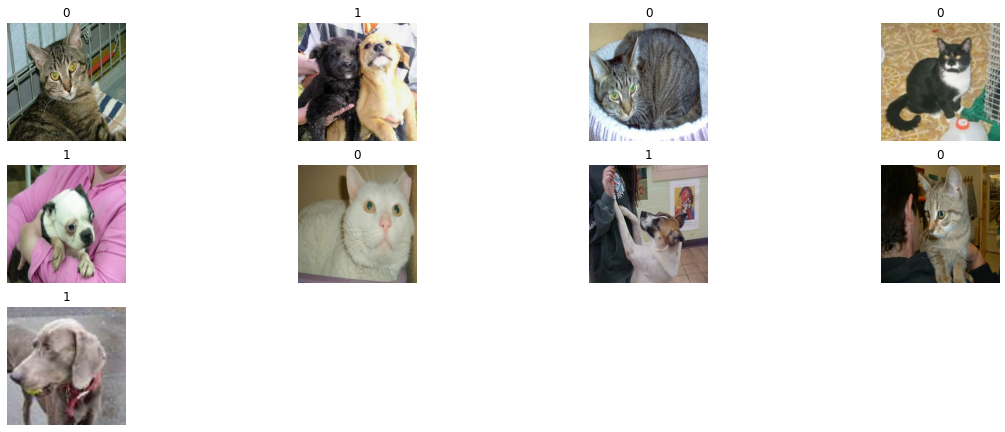

In [8]:
plt.figure(figsize=(20, 10))
for images, labels in data_pet.take(1):
    for i in range(9):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [9]:
batch_size = 64
img_height = 256
img_width = 256

In [10]:
import os
images_skip = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(data_pet_direct, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            images_skip += 1
            os.remove(fpath)
print("Deleting %d images" % images_skip)


Deleting 1590 images


In [11]:
#Data augmentation
images_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)])


In [12]:

training_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_pet_direct,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

validating_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_pet_direct,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 23410 files belonging to 2 classes.
Using 16387 files for training.
Found 23410 files belonging to 2 classes.
Using 7023 files for validation.


In [13]:
cl_names = training_data.class_names
print(cl_names)
cl_names = validating_data.class_names
print(cl_names)

['Cat', 'Dog']
['Cat', 'Dog']


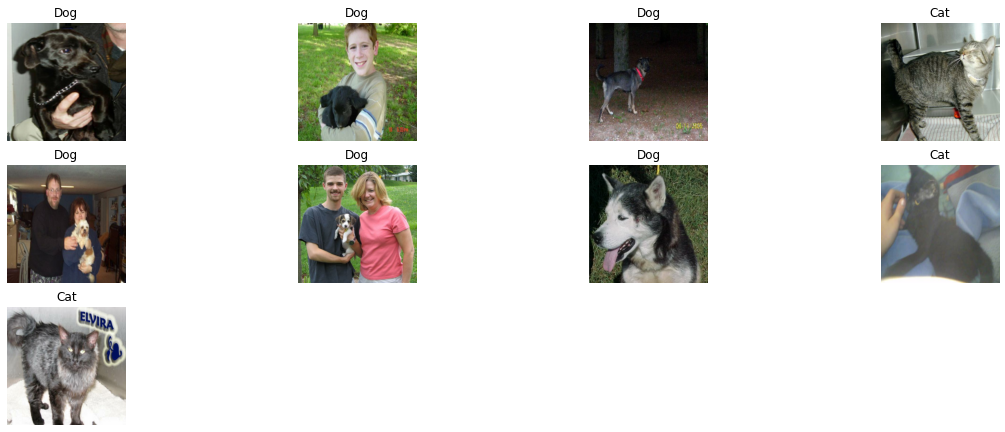

In [14]:
plt.figure(figsize=(20, 10))
for images, labels in training_data.take(1):
  for i in range(9):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(cl_names[labels[i]])
    plt.axis("off")

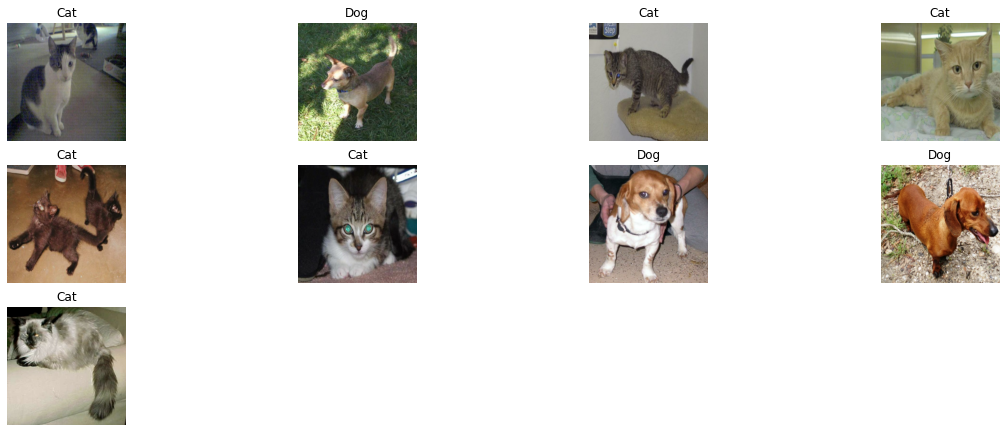

In [15]:
plt.figure(figsize=(20, 10))
for images, labels in validating_data.take(1):
  for i in range(9):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(cl_names[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in training_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 256, 256, 3)
(64,)


In [30]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
first_model = tf.keras.models.Sequential([tf.keras.layers.Rescaling(1./255), 
                                    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (256, 256, 3)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Dropout(0.25),
                                    
                                    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation = 'relu'),
                                    tf.keras.layers.Dense(2, activation = 'softmax')])

In [18]:
first_model.compile(
  optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [20]:
history = first_model.fit(training_data, validation_data=validating_data, epochs=50)

Epoch 1/50
257/257 [==============================] - 59s 229ms/step - loss: 2.0517 - accuracy: 0.5715 - val_loss: 0.6902 - val_accuracy: 0.5102
Epoch 2/50
257/257 [==============================] - 58s 224ms/step - loss: 0.5657 - accuracy: 0.7094 - val_loss: 0.8578 - val_accuracy: 0.5614
Epoch 3/50
257/257 [==============================] - 58s 224ms/step - loss: 0.4788 - accuracy: 0.7736 - val_loss: 0.5959 - val_accuracy: 0.7263
Epoch 4/50
257/257 [==============================] - 58s 224ms/step - loss: 0.4016 - accuracy: 0.8234 - val_loss: 0.4724 - val_accuracy: 0.8069
Epoch 5/50
257/257 [==============================] - 58s 224ms/step - loss: 0.3296 - accuracy: 0.8590 - val_loss: 0.9819 - val_accuracy: 0.6658
Epoch 6/50
257/257 [==============================] - 58s 224ms/step - loss: 0.2679 - accuracy: 0.8894 - val_loss: 0.5146 - val_accuracy: 0.8223
Epoch 7/50
257/257 [==============================] - 58s 224ms/step - loss: 0.2199 - accuracy: 0.9141 - val_loss: 1.4039 - val_ac

In [21]:
first_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)     

In [44]:
first_model.evaluate(validating_data)

110/110 [==============================] - 9s 77ms/step - loss: 2.6170 - accuracy: 0.8431


[2.6170437335968018, 0.8430870175361633]

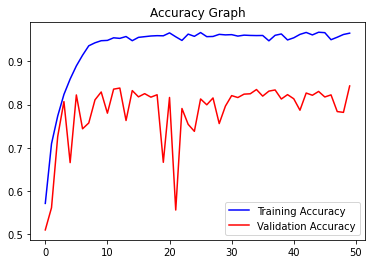

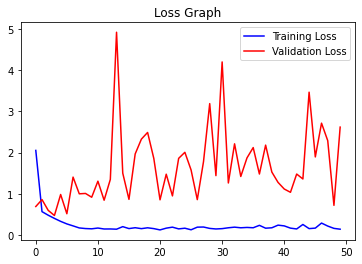

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [149]:
import os
import shutil
import glob

import tensorflow as tf


from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import scipy
import numpy as np
import matplotlib.pyplot as plt

import PIL
import PIL.Image

In [150]:
weight = "/content/inception_v3_weights.h5"
print(type(weight))
print(" ")
print(weight)

<class 'str'>
 
/content/inception_v3_weights.h5


In [187]:
inception_model = InceptionV3(input_shape = (256, 256, 3), 
                                include_top = False, 
                                weights = None)

In [188]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_474 (Conv2D)            (None, 127, 127, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_471 (Batch  (None, 127, 127, 32  96         ['conv2d_474[0][0]']             
 Normalization)                 )                                                      

In [189]:
for layer in inception_model.layers:
  layer.trainable = False
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_474 (Conv2D)            (None, 127, 127, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_471 (Batch  (None, 127, 127, 32  96         ['conv2d_474[0][0]']             
 Normalization)                 )                                                      

In [190]:
from tensorflow.keras.optimizers import RMSprop

In [191]:
last_layer = inception_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 768)


In [194]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

In [195]:
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

inception_model = Model(inception_model.input, x)

In [196]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [197]:
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [161]:
to_create = [
    'cats vs dogs',
    'cats vs dogs/training',
    'cats vs dogs/testing',
    'cats vs dogs/training/cats',
    'cats vs dogs/training/dogs',
    'cats vs dogs/testing/cats',
    'cats vs dogs/testing/dogs'
]

for directory in to_create:
    try:
        os.mkdir(directory)
        print(directory, 'created')
    except:
        print(directory, 'failed')

cats vs dogs created
cats vs dogs/training created
cats vs dogs/testing created
cats vs dogs/training/cats created
cats vs dogs/training/dogs created
cats vs dogs/testing/cats created
cats vs dogs/testing/dogs created


In [198]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import random
from shutil import copyfile

In [199]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    all_files = []
    
    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name

        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))
    
    n_files = len(all_files)
    split_point = int(n_files * SPLIT_SIZE)
    
    shuffled = random.sample(all_files, n_files)
    
    train_set = shuffled[:split_point]
    test_set = shuffled[split_point:]
    
    for file_name in train_set:
        copyfile(SOURCE + file_name, TRAINING + file_name)
        
    for file_name in test_set:
        copyfile(SOURCE + file_name, TESTING + file_name)


CAT_SOURCE_DIR = "PetImages/Cat/"
TRAINING_CATS_DIR = "cats vs dogs/training/cats/"
TESTING_CATS_DIR = "cats vs dogs/testing/cats/"
DOG_SOURCE_DIR = "PetImages/Dog/"
TRAINING_DOGS_DIR = "cats vs dogs/training/dogs/"
TESTING_DOGS_DIR = "cats vs dogs/testing/dogs/"

split_size = .8
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [200]:
print(len(os.listdir('cats vs dogs/training/cats/')))
print(len(os.listdir('cats vs dogs/training/dogs/')))
print(len(os.listdir('cats vs dogs/testing/cats/')))
print(len(os.listdir('cats vs dogs/testing/dogs/')))

11256
11186
4212
4184


In [201]:
train_dir = 'cats vs dogs/training/'

train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures

print("train_cats_dir path is : ", train_cats_dir)
print(" ")
print("train_dogs_dir path is : ", train_dogs_dir)

valid_dir = 'cats vs dogs/testing/'
valid_cats_dir = os.path.join(valid_dir, 'cats') # Directory with our validation cat pictures
valid_dogs_dir = os.path.join(valid_dir, 'dogs')# Directory with our validation dog pictures

print(" ")
print("validation_cats_dir path is : ", valid_cats_dir)
print(" ")
print("validation_dogs_dir path is : ", valid_dogs_dir)

train_cats_dir path is :  cats vs dogs/training/cats
 
train_dogs_dir path is :  cats vs dogs/training/dogs
 
validation_cats_dir path is :  cats vs dogs/testing/cats
 
validation_dogs_dir path is :  cats vs dogs/testing/dogs


In [202]:
train_cat_fnames = os.listdir(train_cats_dir)
train_cat_fnames

['2115.jpg',
 '8338.jpg',
 '10239.jpg',
 '8335.jpg',
 '10988.jpg',
 '6377.jpg',
 '3570.jpg',
 '5461.jpg',
 '4648.jpg',
 '5692.jpg',
 '7796.jpg',
 '9299.jpg',
 '3015.jpg',
 '6877.jpg',
 '12108.jpg',
 '6570.jpg',
 '1171.jpg',
 '8520.jpg',
 '4231.jpg',
 '5420.jpg',
 '9756.jpg',
 '10953.jpg',
 '8755.jpg',
 '29.jpg',
 '10427.jpg',
 '1126.jpg',
 '526.jpg',
 '9989.jpg',
 '9456.jpg',
 '9678.jpg',
 '9638.jpg',
 '3779.jpg',
 '3513.jpg',
 '10021.jpg',
 '838.jpg',
 '6598.jpg',
 '12417.jpg',
 '2766.jpg',
 '3418.jpg',
 '3803.jpg',
 '711.jpg',
 '10833.jpg',
 '2095.jpg',
 '5393.jpg',
 '2136.jpg',
 '8119.jpg',
 '8272.jpg',
 '11710.jpg',
 '10294.jpg',
 '5437.jpg',
 '1842.jpg',
 '11032.jpg',
 '12375.jpg',
 '4517.jpg',
 '662.jpg',
 '564.jpg',
 '9019.jpg',
 '11829.jpg',
 '5811.jpg',
 '956.jpg',
 '1734.jpg',
 '5558.jpg',
 '8358.jpg',
 '5562.jpg',
 '4328.jpg',
 '10814.jpg',
 '2664.jpg',
 '6018.jpg',
 '8617.jpg',
 '558.jpg',
 '6785.jpg',
 '8665.jpg',
 '2272.jpg',
 '10535.jpg',
 '7465.jpg',
 '34.jpg',
 '6080.j

In [203]:
train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames

['2115.jpg',
 '8338.jpg',
 '10239.jpg',
 '10988.jpg',
 '6377.jpg',
 '3570.jpg',
 '4648.jpg',
 '5692.jpg',
 '7796.jpg',
 '9299.jpg',
 '3015.jpg',
 '6877.jpg',
 '9261.jpg',
 '12108.jpg',
 '6570.jpg',
 '1171.jpg',
 '8520.jpg',
 '4231.jpg',
 '5420.jpg',
 '9756.jpg',
 '1359.jpg',
 '10953.jpg',
 '29.jpg',
 '10427.jpg',
 '1126.jpg',
 '526.jpg',
 '9989.jpg',
 '9456.jpg',
 '9678.jpg',
 '9638.jpg',
 '3779.jpg',
 '3513.jpg',
 '10021.jpg',
 '838.jpg',
 '6598.jpg',
 '12417.jpg',
 '2766.jpg',
 '3418.jpg',
 '3803.jpg',
 '711.jpg',
 '10833.jpg',
 '2095.jpg',
 '5393.jpg',
 '2136.jpg',
 '8119.jpg',
 '8272.jpg',
 '11710.jpg',
 '10294.jpg',
 '5437.jpg',
 '1842.jpg',
 '12375.jpg',
 '4517.jpg',
 '662.jpg',
 '564.jpg',
 '9019.jpg',
 '8080.jpg',
 '5811.jpg',
 '956.jpg',
 '1734.jpg',
 '5558.jpg',
 '8358.jpg',
 '5562.jpg',
 '4328.jpg',
 '10814.jpg',
 '2664.jpg',
 '6018.jpg',
 '8617.jpg',
 '558.jpg',
 '6785.jpg',
 '8665.jpg',
 '2272.jpg',
 '10535.jpg',
 '1970.jpg',
 '7465.jpg',
 '34.jpg',
 '6080.jpg',
 '7310.jpg

In [204]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (256, 256))

Found 22440 images belonging to 2 classes.


In [205]:
validation_generator =  test_datagen.flow_from_directory( valid_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (256, 256))

Found 8396 images belonging to 2 classes.


In [206]:
# compile the model
inception_model.compile(optimizer=tf.optimizers.RMSprop(learning_rate = 0.0001),
              loss='binary_crossentropy', 
              metrics=['acc'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss')

In [207]:
history1 = inception_model.fit(train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 50,
            validation_steps = 50,
            verbose = 2)

Epoch 1/50
100/100 - 84s - loss: 0.6926 - acc: 0.5175 - val_loss: 0.6953 - val_acc: 0.5030 - 84s/epoch - 845ms/step
Epoch 2/50
100/100 - 32s - loss: 0.6923 - acc: 0.5135 - val_loss: 0.6924 - val_acc: 0.4860 - 32s/epoch - 322ms/step
Epoch 3/50
100/100 - 32s - loss: 0.6927 - acc: 0.5125 - val_loss: 0.6911 - val_acc: 0.5730 - 32s/epoch - 320ms/step
Epoch 4/50
100/100 - 32s - loss: 0.6917 - acc: 0.5210 - val_loss: 0.6974 - val_acc: 0.4720 - 32s/epoch - 322ms/step
Epoch 5/50
100/100 - 32s - loss: 0.6911 - acc: 0.5235 - val_loss: 0.6893 - val_acc: 0.5070 - 32s/epoch - 323ms/step
Epoch 6/50
100/100 - 32s - loss: 0.6905 - acc: 0.5375 - val_loss: 0.6874 - val_acc: 0.5650 - 32s/epoch - 321ms/step
Epoch 7/50
100/100 - 32s - loss: 0.6916 - acc: 0.5220 - val_loss: 0.6882 - val_acc: 0.5900 - 32s/epoch - 324ms/step
Epoch 8/50
100/100 - 32s - loss: 0.6882 - acc: 0.5385 - val_loss: 0.6870 - val_acc: 0.5410 - 32s/epoch - 322ms/step
Epoch 9/50
100/100 - 32s - loss: 0.6886 - acc: 0.5505 - val_loss: 0.6932

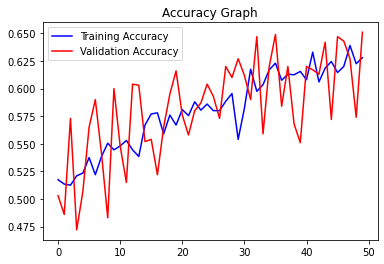

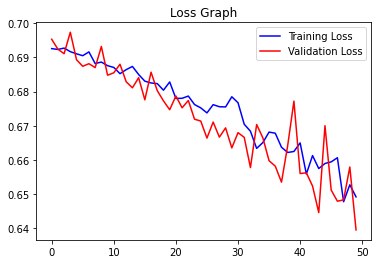

In [211]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history1.history['loss']
val_loss = history1.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()